In [55]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error as mse 
from copy import deepcopy 
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
data = pd.merge(ratings, titles, on='MovieID')


n = data.shape[0]
ntrain = int(np.floor(n*0.8))
nval = n - ntrain
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [56]:
shuffled_data = data.reindex(np.random.permutation(data.index))
train = deepcopy(shuffled_data)
val = deepcopy(shuffled_data)

train['Rating'][ntrain:] = 0
val['Rating'][:ntrain] = 0

train.tail(nval)
val.head(ntrain)
shuffled_data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres
410969,2106,3253,1,975439910,Wayne's World (1992),Comedy
735313,4122,1845,4,965359017,Zero Effect (1998),Comedy|Thriller
200742,647,733,2,975713476,"Rock, The (1996)",Action|Adventure|Thriller
115595,5404,1084,5,960255624,Bonnie and Clyde (1967),Crime|Drama
13317,3118,595,3,969404355,Beauty and the Beast (1991),Animation|Children's|Musical


In [57]:
ground_truth = shuffled_data.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)
train_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)
val_mtx  = val.pivot_table(index='UserID', columns='Title', values='Rating').fillna(0)

print(ground_truth.shape, train_mtx.shape, val_mtx.shape)

print(ground_truth.astype(bool).sum().sum() == n)
print(train_mtx.astype(bool).sum().sum() == ntrain)
print(val_mtx.astype(bool).sum().sum() ==  nval)

train_select =  np.logical_and(train_mtx, np.ones(np.shape(train_mtx)))
val_select = np.logical_and(val_mtx, np.ones(np.shape(val_mtx)))

(6040, 3706) (6040, 3706) (6040, 3706)
True
True
True


In [0]:
# implementing SVD
user_mean = np.mean(train_mtx.as_matrix(),axis=1).reshape(-1,1)
train_centered = train_mtx - user_mean

kmax = 50
Ks = list(range(20, kmax, 2))
history = np.zeros((len(Ks),2))

for i,k in enumerate(Ks):
  # Obtain predictions 
  U, sigma, Vt = svds(train_centered, k)
  sigma = np.diag(sigma)
  pred = np.dot(np.dot(U, sigma), Vt) + user_mean

  # obtain train MSE
  train_pred = np.multiply(pred, train_select)
  history[i,0] = mse(train_pred, train_mtx)

  # obtain val MSE
  val_pred = np.multiply(pred, val_select)
  history[i,1] = mse(val_pred, val_mtx)


Minimum Validation Loss is: 0.06488054872103509
Optimal k: 28


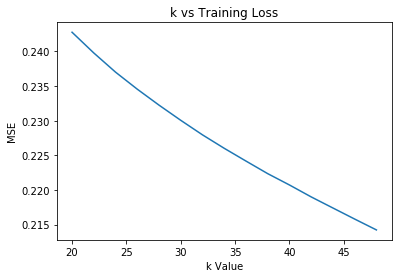

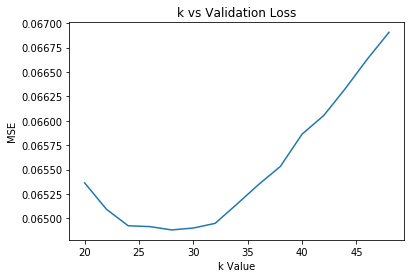

In [59]:
def mse_curve(history, k_range):
  train_loss = history[:,0]
  val_loss   = history[:,1]
  x_axis     = k_range
  
  plt.figure()
  plt.plot(Ks, train_loss, label="Training Loss")
  plt.ylabel('MSE')
  plt.xlabel('k Value')
  plt.title('k vs Training Loss')
  plt.figure()
  plt.plot(Ks, val_loss, label="Validation Loss")
  plt.ylabel('MSE')
  plt.xlabel('k Value')
  plt.title('k vs Validation Loss')
  print('Minimum Validation Loss is:', min(val_loss))
  print('Optimal k:', Ks[np.argmin(val_loss)])
  
mse_curve(history, Ks)

In [62]:
preds_df = pd.DataFrame(pred, columns = ground_truth.columns)

preds_df.head()
# MUST STILL WORK ON RECOMMENDING MOVIES AFTER OBTAINING PREDCTIONS 

Title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),24 7: Twenty Four Seven (1997),24-hour Woman (1998),28 Days (2000),3 Ninjas: High Noon On Mega Mountain (1998),3 Strikes (2000),"301, 302 (1995)","39 Steps, The (1935)","400 Blows, The (Les Quatre cents coups) (1959)",42 Up (1998),52 Pick-Up (1986),54 (1998),"7th Voyage of Sinbad, The (1958)",8 1/2 (1963),8 1/2 Women (1999),8 Heads in a Duffel Bag (1997),8 Seconds (1994),8MM (1999),A Chef in Love (1996),Abbott and Costello Meet Frankenstein (1948),"Abominable Snowman, The (1957)",About Adam (2000),About Last Night... (1986),...,Wonderland (1997),Wonderland (1999),Woo (1998),"Wood, The (1999)","Wooden Man's Bride, The (Wu Kui) (1994)",Working Girl (1988),"World Is Not Enough, The (1999)","World of Apu, The (Apur Sansar) (1959)","Wrong Man, The (1956)","Wrong Trousers, The (1993)",Wrongfully Accused (1998),Wyatt Earp (1994),"X-Files: Fight the Future, The (1998)",X-Men (2000),X: The Unknown (1956),Xiu Xiu: The Sent-Down Girl (Tian yu) (1998),Yankee Zulu (1994),"Yards, The (1999)","Year My Voice Broke, The (1987)",Year of Living Dangerously (1982),Year of the Horse (1997),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You So Crazy (1994),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
0,0.045946,0.050694,-0.003632,-0.021583,0.128187,0.019531,-0.008094,1.212324,0.448521,0.458387,-0.051338,0.022636,0.137302,-0.004652,0.084161,0.003235,0.736065,-0.000236,0.020254,0.020622,0.040599,0.036790,0.019183,0.019901,-0.026314,-0.024815,0.046566,-0.003947,-0.019268,-0.119813,0.027853,0.023189,-0.029045,0.071045,0.059682,-0.006886,0.100938,0.005242,0.011864,0.134127,...,-0.010171,-0.023368,0.017485,0.002537,0.015593,0.126461,0.124406,0.031533,-0.108316,0.817784,-0.057943,-0.191924,-0.248551,0.420950,0.005404,0.007569,0.019887,0.020489,0.047488,-0.011115,0.018150,0.372904,-0.102172,0.008870,0.037030,0.193877,-0.026355,0.302487,-0.200426,-0.140036,0.052049,-0.208643,0.022095,0.031272,0.010548,0.002954,0.025615,0.025511,0.035989,-0.057205
1,0.007248,0.114918,-0.012952,-0.095869,0.308150,-0.019586,0.234144,0.121791,0.102401,0.906834,0.451835,0.019112,-0.066910,-0.016603,-0.000958,0.006068,0.494157,-0.021266,-0.031426,-0.028787,0.070781,0.018315,-0.013073,-0.039346,0.016521,0.296594,-0.038019,-0.030375,0.026092,0.011793,0.231459,-0.037096,0.059519,0.038412,-0.001045,0.014284,0.104829,-0.023970,-0.027415,0.090747,...,0.011132,-0.035845,-0.014570,-0.056837,-0.014289,0.063033,0.759834,-0.004036,-0.132824,-0.429691,0.102384,-0.084101,0.184757,0.976390,-0.025240,0.021655,-0.013804,-0.074243,0.007052,0.760007,-0.016619,-0.110571,0.016841,-0.000691,-0.057005,0.359822,-0.081228,-0.429461,0.082681,0.181231,-0.102466,0.029138,-0.009923,-0.138270,-0.014079,-0.028234,-0.156974,-0.034871,-0.025511,-0.018456
2,-0.013762,-0.064227,-0.056663,-0.054044,-0.018666,0.005619,0.002754,-0.153839,0.081775,-0.211495,0.224739,0.033596,0.102928,0.010750,-0.236048,-0.000559,-0.730215,-0.395570,0.007767,-0.002246,0.031537,-0.010624,0.003599,0.008117,-0.134115,0.024964,0.040259,0.094748,-0.095532,0.015853,0.006533,0.020551,0.030205,0.083961,0.100217,0.032227,0.061828,-0.007944,-0.008027,-0.044571,...,0.004216,-0.023267,0.005393,-0.045131,0.002794,-0.040028,0.197939,0.002672,-0.061773,0.562410,0.02